In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
from IPython.display import HTML
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; left: 10px; 
              background: transparent;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv id=media-mobile>
    <h4>MENU</h4><br>
    <a href=#Constant_Yields>1. Constant Yields</a><br>
    <a href=#Family_Farms>2. Family Farms</a><br> 
    <a href=#Farm_Size_Proxy>3. Farm Size Proxy</a><br>
    <a href=#Spatial_Bias>4. Spatial Bias</a><br>  
    <a href=#Data_Comparisons>5. Other Datasets</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    
    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='../Project_Overview'>Project Overview</a><br>
    <a href='../Data_Coverage'>Data Coverage</a><br>
    <a href='../General_Results'>General Results</a><br>
    <a href='../Global_Estimate'>Global Estimates</a><br>
    <a href='../Crop_Diversity'>Crop Diversity</a><br>
    <a href='../Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>Sensitivity Analyses</h1></center><br><br>

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.pyplot import cm 
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import numpy as np
import re
import geopy
import mpld3
import plotly.plotly as py
import cmocean
# from pysal.esda import mapclassify as mpc
from collections import OrderedDict
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from matplotlib.ticker import MaxNLocator
from scipy import stats

pd.set_option('display.max_columns', 500)
%matplotlib inline

In [61]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])

    data['production_kcal'] = data['Production_fix'] * data['kcal']
    data['production_kcal_k'] = data['Production_constant'] * data['kcal']
    
    data = data.replace(0.0, np.nan)  # there were many zero values, fix  needed zeros below
    
    data['Production_fix_dummy'] = np.where(data['Production'].notnull(), 0, 
                                            np.where(data['Production_fix'].notnull(), 1, np.nan))
    data['cen_sur'] = np.where(data['cen_sur'] == 'sur', 1., 0.)
    data['fs_proxy'] = np.where(data['fs_proxy'].isnull(), 0, data['fs_proxy'])
    
    return data

In [62]:
try:
    PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    df = read_data_init(PATH)
except:
    PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    df = read_data_init(PATH)

In [63]:
yield_k = len(df['NAME_0'].unique()) - len(df.query("Production_fix_dummy == 0")['NAME_0'].unique())
family = len(df.query("cen_sur == 1")['NAME_0'].unique())
fs_proxy = len(df.query("fs_proxy == 1")['NAME_0'].unique())

yield_k_prod = round(100 * df.query("Production_fix_dummy == 1")['production_kcal'].sum() / 
                     df['production_kcal'].sum(), 1)

family_prod = round(100 * df.query("cen_sur == 1")['production_kcal'].sum() / 
                    df['production_kcal'].sum(), 1)

fs_proxy_prod = round(100 * df.query("fs_proxy == 1")['production_kcal'].sum() / 
                      df['production_kcal'].sum(), 1)

This section performs three sensitivity analyses on our dataset:
1. Constant yields
2. Family farms
3. Harvested/cropped/planted/plot area as a proxy for farm size
4. Spatial bias
5. Comparisons to other datasets

These three sensitivity analyses are neccessary to preform due to data collection constraints and are detailed below.<br>

1. For {{yield_k}} countries, representing {{yield_k_prod}}% of the total production (in kcal), we could not find crop production by farm size, but we did find either crop area, harvest area, planted area, or plot area by farm size per crop. We then used FAO yield estimates for the given country and crop to estimate production per farm size. Hence, we need to better understand how using a constant yield across farm sizes may bias our production estimates since there is a widely observed inverse yield to farm size relationship where smaller farms typically have higher yields. This assumption may bias our results towards larger farms.<br><br>

2. For {{family}} countries, representing {{family_prod}}% of the total production (in kcal), we could not find agricultural census data, but we did find nationally representative (or even subnationally representative) agricultural household surveys. Many of these surveys were in microdata format, meaning we have access to the individual household survey for each respondent. One bias that stems from the household surveys is that they do not capture commercial enterprises, only family farms. Since family farms make up, on average 53% (Graeub et al. 2016) to 73.5% (Lowder et al. 2015) of the global cropping area. This assumption may be biasing our results towards smaller farms.<br><br>

3. For {{fs_proxy}} countries, representing {{fs_proxy_prod}}% of the total production (in kcal), farm size was not reported specifically, but we were able to calsulate a proxy farm size using the sum of either harvested, cropped, planted, or plot area. This assumption may be biasing our results towards smaller farms. (note, this bias might not be able to be tested using our existing data sources).
<br><br>

4. Since our dataset is a convenience sample, we were not able to control the countries omitted. As such, our dataset accounts for around 50% of the total global harvest area, with decent representation across country types (e.g., spatial and economic). However, there area large data gaps for Australasia and Asia. As part of our efforts to estimate global ranges for the percentage of food production by each farm size group, we detail how the countries within our dataset bias our results.<br><br>

5. In an effort to minimize data errors, our data was checked iteratively with FAO country level estimates. Additionally, we compare our data with Lowder et al.'s (2015) country level farm size distributions by area and Herero et al.'s (2017) global and regional calculations for the amount of fod procuced by varying farm size classes.

<a name="Constant_Yields"></a>
<h2>Constant Yields</h2><br>

In [64]:
def plot_bias(data, variable='variable', bias='None', nobias='None'):

    data['NAME_0'].replace(['United States of America'], ['United States'], inplace=True)
    data['NAME_0'].replace(['Bosnia and Herzegovina'], ['Bosnia and Herz.'], inplace=True)
    data['NAME_0'].replace(['United Republic of Tanzania'], ['Tanzania'], inplace=True)
    data['NAME_0'].replace(['Russian Federation'], ['Russia'], inplace=True)
    data['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
    data['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
    data['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)


    pivoted = pd.pivot_table(data, 
                             index='NAME_0', 
                             values=variable,
                             aggfunc=np.nanmean)
    
    pivoted = pivoted.reset_index()
    pivoted = pivoted.sort_values(variable, ascending=False)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
    world = world.to_crs("+proj=robin") # world.to_crs(epsg=3395) would also work
    world = pd.merge(world, pivoted, 
                     how='outer', 
                     left_on='name', 
                     right_on='NAME_0')

    if variable is 'Production_fix_dummy':

        world[variable] = np.where(world[variable] == 0.0, 
                                   'nobias',
                                   np.where((world[variable] > 0.0) & (world[variable] < 0.25), 
                                            'lowbias',
                                            np.where((world[variable] > 0.25) & (world[variable] < 0.75), 
                                                     'mediumbias',
                                                     np.where(world[variable] > 0.75, 
                                                              'highbias', 'nodata'))))
        
        colors = OrderedDict([('highbias',   '#ec7014'),
                              ('lowbias',    '#fec44f'),
                              ('mediumbias', '#fe9929'),
                              ('nobias',     '#fee391'),
                              ('nodata',     '#ffffd4')])

        cmap = LinearSegmentedColormap.from_list('mycmap', [colors['highbias'],
                                                            colors['lowbias'], 
                                                            colors['mediumbias'], 
                                                            colors['nobias'],
                                                            colors['nodata']])


    else:
        
        world[variable] = np.where(world[variable] == 0., 'nobias',
                                   np.where(world[variable] == 1., 'bias', 'nodata'))

        colors = {'nobias': '#beaed4',
                  'bias':   '#fdc086',
                  'nodata': '#f2f0f7'}  

        cmap = LinearSegmentedColormap.from_list('mycmap', [colors['bias'],
                                                            colors['nobias'], 
                                                            colors['nodata']])
    
    
    warnings.filterwarnings('ignore')
    

    try:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_aspect('equal')
        world.plot(column=variable, 
                   cmap=cmap,  
                   alpha=1., 
                   linewidth=0.1,
                   ax=ax)
    except:
        pass

    dictionary = dict(world[variable].value_counts())
    
    if variable is 'Production_fix_dummy':

        p1 = mpl.lines.Line2D([], [], 
                                     color=colors['nobias'],
                                     linewidth=10, 
                                     label='Actual production')

        p2 = mpl.lines.Line2D([], [], 
                                     color=colors['lowbias'], 
                                     linewidth=10, 
                                     label='Low bias   < 25%')
                                   
        p3 = mpl.lines.Line2D([], [], 
                                     color=colors['mediumbias'], 
                                     linewidth=10, 
                                     label='Medium bias')

        p4 = mpl.lines.Line2D([], [], 
                                     color=colors['highbias'], 
                                     linewidth=10, 
                                     label='High bias  > 75%')

        p5 = mpl.lines.Line2D([], [], 
                                     color=colors['nodata'], 
                                     linewidth=10, 
                                     label='Data not found')

        handles = [p1, p2, p3, p4, p5]

    else:
        
        p1 = mpl.lines.Line2D([], [], 
                                     color=colors['nobias'],
                                     linewidth=10, 
                                     label='{}'.format(nobias))

        p2 = mpl.lines.Line2D([], [], 
                                     color=colors['bias'], 
                                     linewidth=10, 
                                     label='{}'.format(bias))

        p3 = mpl.lines.Line2D([], [], 
                                     color=colors['nodata'], 
                                     linewidth=10, 
                                     label='Data not found')

        handles = [p1, p2, p3]
        
    labels = [h.get_label() for h in handles] 

    legend = ax.legend(handles=handles, labels=labels, frameon=True, 
                       fontsize=14, loc='lower left')

    legend.get_frame().set_facecolor('#ffffff')
    
    ax.set_axis_bgcolor("#323232")
    ax.grid(alpha=0.0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    
    fig.savefig('/Users/Vinny_Ricciardi/Desktop/{}.png'.format(variable), dpi=1000, bbox_inches='tight')

    return plt.show()

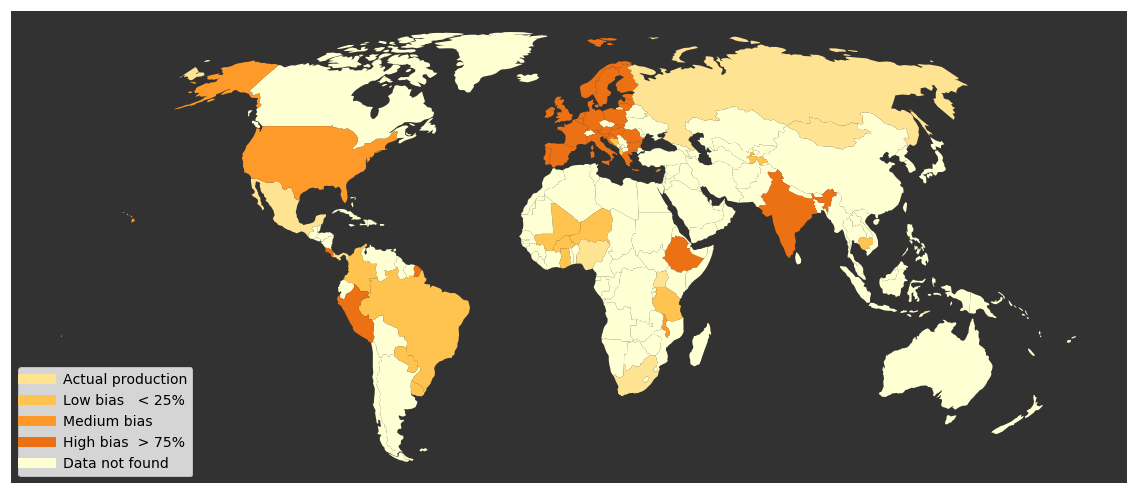

In [65]:
plot_bias(df, variable='Production_fix_dummy')

In [66]:
tmp = df.copy()
names_nobias = len(tmp.loc[(tmp['production_kcal'] > 0.) & (tmp['production_kcal_k'] > 0.)]['NAME_0'].unique())
names_bias = len(tmp.loc[tmp['production_kcal'] == 1.]['NAME_0'].unique())
perc_prod = round(100 * tmp.loc[(tmp['production_kcal'] > 0.) & 
                                (tmp['production_kcal_k'] > 0.)]['production_kcal'].sum() / 
                  tmp['production_kcal'].sum(), 1)

Constant yields were used for particular crops in any country that had an area measurement (i.e., harvested, cropped, planted, or plot area) per crop per farm size but did not have a crop production by farm size. Eight countries reported all of their crop production by farm size and {{names_bias}} countries only reported area per crop by farm size. All remaining countries has a combination of reporting actual production or area by crop by farm size. 

In order to test whether there is a bias in our results from using constant yields for {{yield_k_prod}}% of the total production in our data, we calculated production from constant yeilds for the countries we have both area and production by farm size. In this way we can test if using constant yields changes our production estimates. We have {{names_nobias}} countries with both production and area per crop by farm size that we can use in this test. The data used in the test represents {{perc_prod}}% of our total crop production used.

In [67]:
try:
    world = gpd.read_file('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/Shapefile/FSize.shp')
except:
    world = gpd.read_file('/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/Shapefile/FSize.shp')
world = world.query("geometry == geometry")
world = world.to_crs({'init': 'epsg:3410'})
world['area'] = world['geometry'].area
world = world.loc[:, ['shpID', 'area']]

In [78]:
def prep_yield_data(data):
    
    data = pd.merge(data, world, on='shpID', how='left')
    data = data.loc[data['Production_fix_dummy'] == 0.]
    data = data.loc[(data['production_kcal'] > 0.) & (data['production_kcal_k'] > 0.)]
    
    data = data.loc[data['NAME_0'] != 'Tanzania']  # The area values for these countries did not make sense-but the production values did
    
    data['production_kcal'] = data['production_kcal'] / data['area']                   # weights by shpID area
    data['production_kcal_k'] = data['production_kcal_k'] / data['area']               # weights by shpID area
    
    data = data.loc[(data['production_kcal'] > 0.) & (data['production_kcal_k'] > 0.)]   
    data = data.loc[:, ['NAME_0', 'Farm_Sizes', 'production_kcal', 'production_kcal_k']]
    
    # p_corr =  round(data['production_kcal_k'].corr(data['production_kcal'], method='pearson'), 3)
    # s_corr =  round(data['production_kcal_k'].corr(data['production_kcal'], method='spearman'), 3)
    s_corr = spearmanr(data['production_kcal_k'], data['production_kcal'])
    
    return data, s_corr
    
    
def log_log_plot_yields(ax=None, 
                        data=df, 
                        xlab='Production from constant yields', 
                        ylab='Actual production',
                        title_lab='Log-log plot \n production using constant yields vs actual production\n'):
    
    tmp = prep_yield_data(data)[0]
    
    sns.regplot(np.log(tmp['production_kcal_k']), 
                np.log(tmp['production_kcal']), 
                data=tmp,
                line_kws={'color':'#72B7A1'},
                scatter_kws={'color': '#E79676'},
                ax=ax)
        
    ax.set_xlabel('\n{} (log (kcal))\n\n'.format(xlab), fontsize=18)
    ax.set_ylabel('{} (log (kcal))\n'.format(ylab), fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
 
    return ax
    
    
def boxplot_fsize_yields(ax=None, 
                         data=df,
                         lab1='Actual production',
                         lab2='Production from constant yields', 
                         title_lab='Production using \nconstant yields vs actual production \nby farm size\n'):
    
    tmp = prep_yield_data(data)[0]
    
    tmp = pd.melt(tmp, 
              id_vars='Farm_Sizes', 
              value_vars=['production_kcal', 'production_kcal_k'])
    
    fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                '(500, 1000]', '(1000, 100000]']

    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    tmp['ix'] = tmp['Farm_Sizes'].map(dictionary)
    tmp = tmp.sort_values('ix')
    tmp['value'] = np.log(tmp['value'])
    
    sns.boxplot(x='ix',
                y='value', 
                hue='variable', 
                data=tmp,  
                palette=sns.color_palette("Set2", 3),  
                ax=ax)
    
    ax.set_xlabel('Farm Sizes (ha)', fontsize=18)
    ax.set_ylabel('Production log (kcal)\n', fontsize=18)
    labels = [x[1:-1] for x in fs_order]
    ax.set_xticks(np.arange(len(labels)) + 1)  # Makes space for legend
    ax.set_xticklabels(labels[:-1] + ['', ''], rotation=45);
    ax.tick_params(axis='both', which='major', labelsize=16)

    handles, labels = ax.get_legend_handles_labels()
    labels = [lab1, lab2]
    legend = ax.legend(handles[::-1], 
                       ['Actual', 'Constant'],
                       fontsize=16,
                       loc=[0.88, 0.4], 
                       frameon=True)
    
    frame = legend.get_frame()
    frame.set_color('#ffffff')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax
    
    
def boxplot_yeilds(ax=None, 
                   data=df,
                   x1_lab='Actual Production',
                   x2_lab='Production from \nconstant yields',
                   title_lab='Production using \nconstant yields vs actual production\n'):
    
    tmp = prep_yield_data(data)[0]
    tmp = pd.melt(tmp,
                  id_vars='Farm_Sizes', 
                  value_vars=['production_kcal', 'production_kcal_k'])
   
    sns.boxplot(x=tmp['variable'], 
                y=np.log(tmp['value']), 
                data=tmp, 
                palette=sns.color_palette("Set2", 3), 
                ax=ax)
    
#     ax.set_title(title_lab, fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('Production log(kcal)\n', fontsize=18)
    ax.set_xticklabels([x1_lab, x2_lab])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

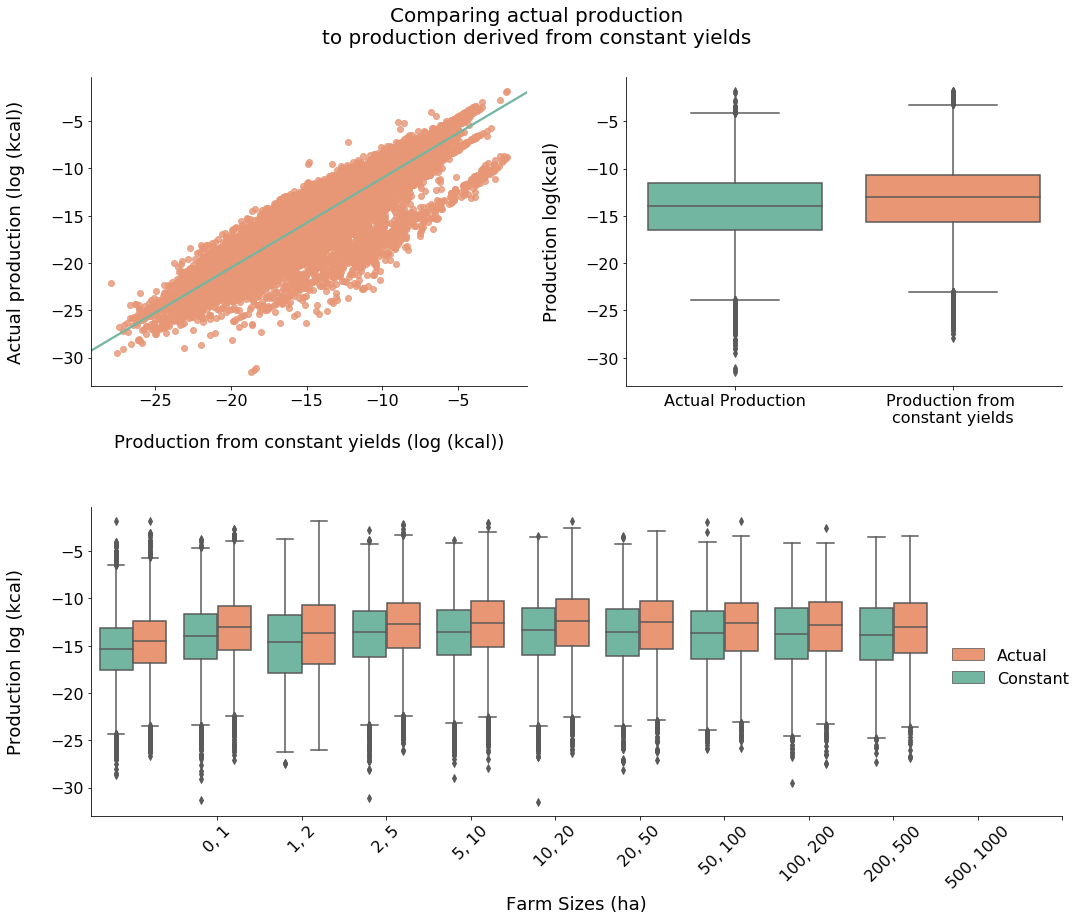

In [79]:
tmp, s_corr = prep_yield_data(df)
cohens_d = round(((tmp['production_kcal'].mean() - tmp['production_kcal_k'].mean()) / 
                  (tmp['production_kcal'].std()**2 + tmp['production_kcal_k'].std()**2)),
                  4)

fig = plt.figure(figsize=[15, 13])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(212)
ax3 = fig.add_subplot(222)

log_log_plot_yields(ax=ax1)
boxplot_fsize_yields(ax=ax2)
boxplot_yeilds(ax=ax3)

fig.suptitle('Comparing actual production\nto production derived from constant yields', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.92])

fig.savefig('/Users/Vinny_Ricciardi/Desktop/sens_constant_panel.png', dpi=1000, bbox_inches='tight')
plt.show();

The left is a log-log plot that shows a very correlated relationship between using constant yields and actual yields. The log-log plot was used due to long tailed distributions in the data. The correlations presented in the chart were calculated from the raw (non-logged) data. The Spearman rank correlation shows {{s_corr}}, which accounts for any skew in the data (and hence is more related to the log-log plot shown).

On the right, there is a box plot comparing actual production with production calculated from constant yields. There is a slight increase in production from using constant yields, but it is negligible as the effect size (Cohen's D = (mean1 - mean2) / std(mean1 or 2)) is only {{round(cohens_d, 2)}} (the table below shows Cohen's d for each farm size class). The bottom bar graph shows that each farm size has very similar means and variance between the actual produciton and the constructed production. Part of this variation may be explained because we used regional yields or global yields where country level yield estimates were not available. Regional and global yields were used for 0.02% of the values, and had a Spearman rank correlation of 0.86 with the FAO country level yields; these are folded into the above analysis.

These results indicate that we have low bias introduced into our study when we use area by crop by farm and constant yields to estimate crop production by farm size.

In [13]:
fs = []
cs = []
ds = []

for f in tmp['Farm_Sizes'].unique():
    tmp2 = tmp.loc[(tmp['Farm_Sizes'] == f) & 
                   (tmp['production_kcal'].notnull()) & 
                   (tmp['production_kcal_k'].notnull())]
    corr_ = spearmanr(tmp2['production_kcal'], tmp2['production_kcal_k'])
    
    tmp2['production_kcal'] = np.log(tmp2['production_kcal'])
    tmp2['production_kcal_k'] = np.log(tmp2['production_kcal_k'])
    
    pooled_sd = np.sqrt(((tmp2['production_kcal'].std()**2) + (tmp2['production_kcal_k'].std()**2)) / 2)
    
    cohens_d = (tmp2['production_kcal'].mean() - tmp2['production_kcal_k'].mean()) / pooled_sd 
    
    fs.append(f)
    cs.append(corr_)
    ds.append(cohens_d)

out = pd.concat([pd.DataFrame(fs, columns=['Farms_Sizes']),
                 pd.DataFrame(cs, columns=['corrs_v', 'corrs_p']),
                 pd.DataFrame(ds, columns=['cohensd'])], axis=1)
out

,Farms_Sizes,corrs_v,corrs_p,cohensd
0,"(0, 1]",0.910343,0.0,-0.246457
1,"(1, 2]",0.917456,0.0,-0.258647
2,"(2, 5]",0.901349,0.0,-0.236602
3,"(5, 10]",0.926724,0.0,-0.254707
4,"(10, 20]",0.930657,0.0,-0.254112
5,"(20, 50]",0.932379,0.0,-0.257497
6,"(50, 100]",0.932335,0.0,-0.247615
7,"(100, 200]",0.937502,0.0,-0.225788
8,"(200, 500]",0.946809,0.0,-0.196012
9,"(500, 1000]",0.955909,0.0,-0.157523


The figure below compares the distributions per farm size class when using constant and actual yields. 

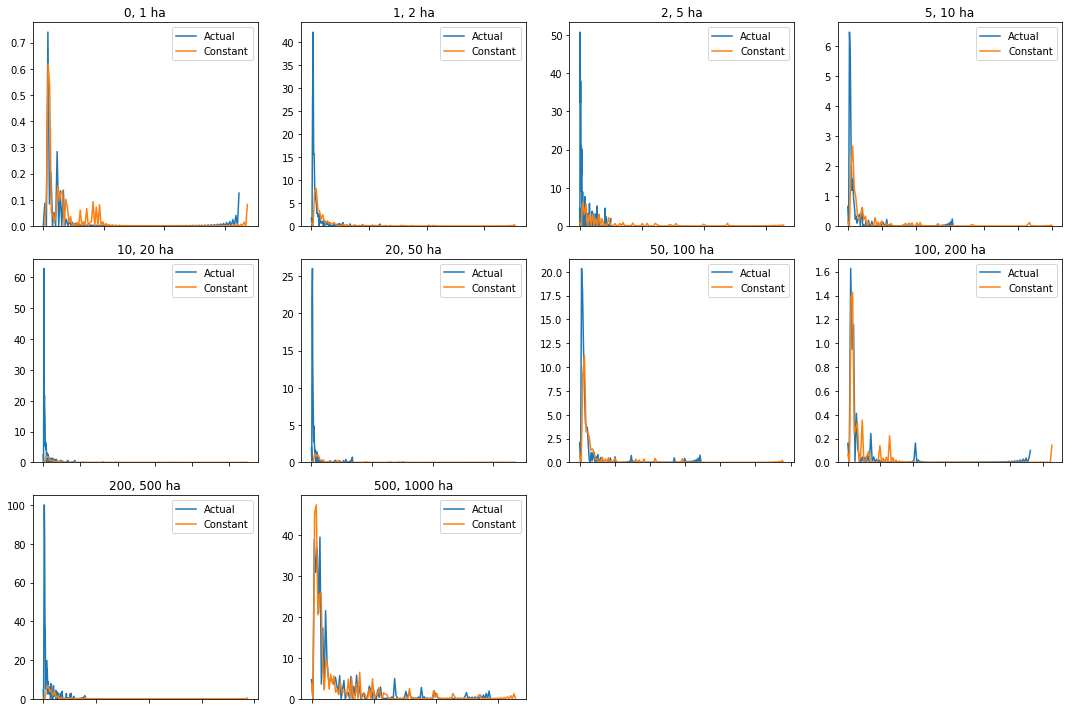

In [14]:
fig = plt.figure(figsize=[15, 10])
fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']

dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
tmp['ix'] = tmp['Farm_Sizes'].map(dictionary)
tmp = tmp.sort_values('ix')

for i in xrange(0, len(tmp['Farm_Sizes'].unique())):
    tmp2 = tmp.loc[(tmp['Farm_Sizes'] == tmp['Farm_Sizes'].unique()[i]) & 
                   (tmp['production_kcal'].notnull()) & 
                   (tmp['production_kcal_k'].notnull())]
                
    ax = fig.add_subplot(3,4,i+1)
    sns.kdeplot(tmp2['production_kcal'], ax=ax, label='Actual')
    sns.kdeplot(tmp2['production_kcal_k'], ax=ax, label='Constant')
#     sns.regplot(np.log(tmp2['production_kcal']), np.log(tmp2['production_kcal_k']), ax=ax)
    ax.set_title(str(tmp['Farm_Sizes'].unique()[i][1:-1]) + ' ha')
    labels = ax.get_xticklabels()
    labels = [item.get_text() for item in labels]
    ax.set_xticklabels(labels, rotation=45)
    
fig.tight_layout()
plt.show()

<a name="Family_Farms"></a>
<h2>Family Farms</h2><br>

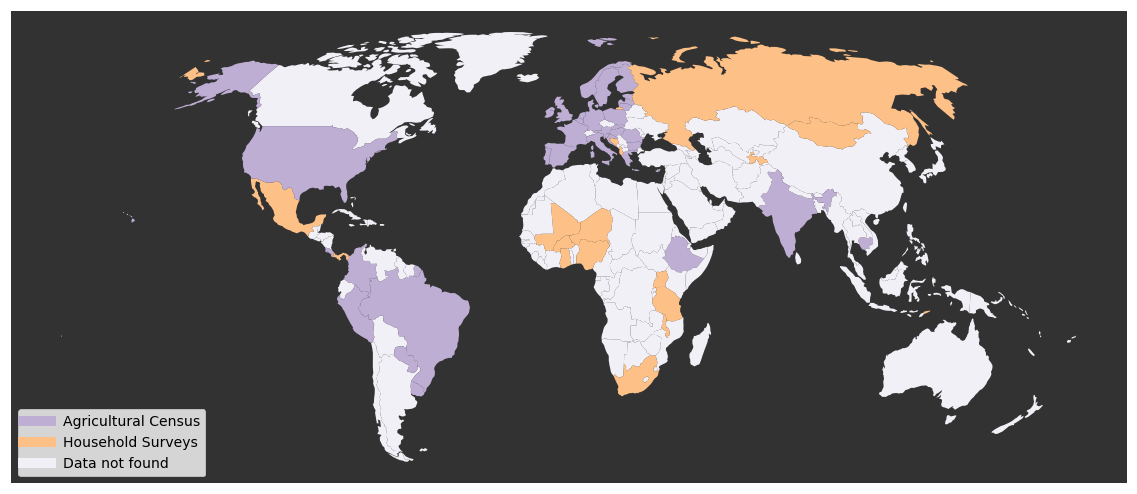

In [15]:
plot_bias(df, variable='cen_sur', bias='Household Surveys', nobias='Agricultural Census')

In [16]:
tmp = df.copy()
names_nobias = len(tmp.loc[tmp['cen_sur'] == 0.]['NAME_0'].unique())
names_bias = len(tmp.loc[tmp['cen_sur'] == 1.]['NAME_0'].unique())
perc_prod = round(100 * tmp.loc[tmp['cen_sur'] == 1.]['production_kcal'].sum() / tmp['production_kcal'].sum(), 1)
perc_prod_food = round(100 * tmp.loc[tmp['cen_sur'] == 1.]['production_Food_kcal'].sum() / tmp['production_Food_kcal'].sum(), 1)

The household survey data may bias our results towards the inclusion of more family farms, which are associated with smaller farms. {{names_nobias}} of the countries we collected were from agriculutral census data and thus have no bias towards family farms since these datasets interview every farm in a given country. {{names_bias}} of the countries in our dataset were based on nationally representative (or even subnational) household surveys, representing {{perc_prod}}% of total crop production {{perc_prod_food}}% food specific crop production in our data.

According to Lowder et al. 2014 family farms make up average of 73.5% of agricultural land in the 77 countries analyzed, while Graeub et al. 2016 found an average of 53% in 105 countries analyzed. The Lowder et al. dataset contains 1 overlapping country with our data, Albania, which was from a census round in 1998 and estimated that 24% of the agricultural land as family farms. From Graeub et al.'s dataset we had 5 countries overlap (Malawi, Mali, Tanzania, Mexico, and Panama); on average these countries had 25.5% of the agricultural land farmed by family farms. 

However, there is a major caveat using the Lowder et al. and/or Graeub et al. data because 4 of the 5 countries we could compare, were defined by Graeub et al. as being a family farm if it was either farms below 10 ha or 2 ha instead of actually by family farm designation; Lowder et al. offers no discrete definition for each countries' family farm estimate.

To demonstrate that Lowder et al. and Graeub et al.'s definition of family farms are not accurate bias estimates to use for the amount of agricultural area (vís-a-vís a proxy for production), we look at Uruguay and Colombia: the only countries in our dataset that contains agricultural census data at the microdata level with a variable to subset the data for family or commercial enterprises. 

For Uruguay, the variable we used to subset family versus commercial enterprises asked whether the legal condition ('Condición Jurídica') of a farm was either a: 

1. Persona física (Family enterprise - actual physical person)
2. Sociedad sin contrato, dependencias estado, otros (Private enterprise)
3. Sociedad con contrato (Public/Private partnership/enterprise)

Both Lowder et al. and Graeub et al. used 2000 census information to estimate that Uruguay had 63% and 15.5% respectively of its agricultural area under family farm management. While Lowder et al. gave no definition for their family farm estimate (except a citation for a government of Uruguay presentation), Greub et al.'s calculation was based on a proxy measurement where any farm < 5 ha was considered a family farm. To test this discrepancy, we subset the Uruguay 2011 census (the 2000 census was not available in microdata format and thus unable to test) based on an actual question about family farms (Persona fîsica) and found that 53% of all agricultural area was under family farm management.

For Colombia, it was more difficult to subset the data. The variable we used to subset family versus commercial enterprises asked whether the farm was organized  ('Usted está organizado') as:

1.	Persona natural (Family enterprise - actual physical person)
2.	Persona Jurídica (empresa, cooperativa, institución, entidad étnico territorial, etc.) (Private enterprise, cooperative, institution, etc.)
3.	Mixta (Persona natural y Persona Jurídica) (A mix of 1 and 2).

Data for Colombia was only available as a comparison in Graeub et al., who used 2001 census information to estimate that 7.85% respectively of Colombia's agricultural area under family farm management. Graeub et al.'s calculation was based on a proxy measurement where any farm under 10 ha was considered a family farm. We found that 82.51% of Colombia's agricultural area was under family farm management. However, there seems to be heavy conflation in between the family farm definitions for the variable that we found regarding family farms and as such, this should not be used to estimate a family farm bias. Hence, we cannot put a bias estimate on our data. More research needs to be done in understanding the relationship between family farms and farm size.

In [17]:
# Below is code for comparing Uruguay's family farms to commercial enterprises. 
# We did not include this since Uruguay has very large farms and hence the 
# relaitonship between farm size distributions and family farms cannot be tested here.


# # path = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Countries_raw_dbs_NEW_Brenton_computer_download_09052017/Household_Survey_Data/Sensitivity_Analyses/Uruguay_Family/FarmSize_data_fullyProcessed.csv'
# # df_fam = read_data_init(path)
# try:
#     PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/Sensitivity_Analyses/Uruguay_Family/FarmSize_data_fullyProcessed.csv'
#     df_fam = read_data_init(PATH)
# except:
#     PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/Sensitivity_Analyses/Uruguay_Family/FarmSize_data_fullyProcessed.csv'
#     df_fam = read_data_init(PATH)



# df_fam = df_fam[df_fam['NAME_0']== 'Uruguay']

# df_fam_f = df_fam.loc[df_fam['NAME_2'] == 'Family']
# df_fam_a = df_fam.loc[df_fam['NAME_2'] != 'Family']

# df_fam_f = df_fam_f.loc[:, ['NAME_0', 'NAME_1', 'NAME_2', 'Farm_Sizes', 'production_Food_kcal']]
# df_fam_a = df_fam_a.loc[:, ['NAME_0', 'NAME_1', 'NAME_2', 'Farm_Sizes', 'production_Food_kcal']]

In [18]:
# tmp = pd.merge(df_fam_f, df_fam_a,
#                on=['NAME_0', 'NAME_1', 'Farm_Sizes'],
#                how='outer')

# tmp = tmp.loc[:, ['NAME_1', 'Farm_Sizes', 'production_Food_kcal_x', 'production_Food_kcal_y', 'shpID']]
# tmp.columns = ['NAME_1', 'Farm_Sizes', 'production_kcal', 'production_kcal_k', 'shpID']

# tmp, p_corr, s_corr = prep_yield_data(tmp)
# cohens_d = round((tmp['production_kcal'].mean() - tmp['production_kcal_k'].mean()) / tmp['production_kcal'].std(), 4)
# cohens_d
# p_corr

# fig = plt.figure(figsize=[15, 10])
# ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(222)
# log_log_plot_yields(ax=ax1,
#                     data=tmp, 
#                     xlab='family farms', 
#                     ylab='all farms',
#                     title_lab='Log-log plot \n production of family farms vs all farms\n')
# bar_plot_yields(ax=ax2,
#                 data=tmp,
#                 lab1='Family farms',
#                 lab2='All farms',
#                 title_lab='Production for \nfamily farms vs all farms \nby farm size\n')
# boxplot_yeilds(ax=ax3,
#                data=tmp,
#                x1_lab='Family farms',
#                x2_lab='All farms',
#                title_lab='Production for \nfamily farms vs all farms\n')
# fig.tight_layout()
# plt.show();

In [19]:
# tmp.head()
# pivot = pd.pivot_table(tmp, index='Farm_Sizes', aggfunc=np.nansum).reset_index()
# pivot['perc_prod_fam'] = 100 * pivot['production_kcal'] / pivot['production_kcal'].sum()
# pivot['perc_prod_all'] = 100 * pivot['production_kcal_k'] / pivot['production_kcal_k'].sum()
# pivot['cumsum_family'] = np.cumsum(pivot['perc_prod_fam'])
# pivot['cumsum_all'] = np.cumsum(pivot['perc_prod_all'])
# pivot.loc[:, ['Farm_Sizes', 'cumsum_family', 'cumsum_all']]

In [20]:
# The largest farm sizes have a lot more food specific production by large producers when we do not subset family farms, which seems to drive the low correlations. Hence, if we used Uruguay as a proxy for the countries we used sample surveys for {{names_nobias}} countries (representing {{perc_prod_food}}% of food specific crop production in our data) we will be underestimating this largest farmsize category. However, Uruguay is country with 91% of the food specific crop production in our dataset coming from the largest farm size class and may not be the best measure for the Sub-Saharan African and Eastern European countries making up the majority of countries in our data set with this family farm bias.

<a name="Farm_Size_Proxy"></a>
<h2>Farm Size Proxy</h2><br>

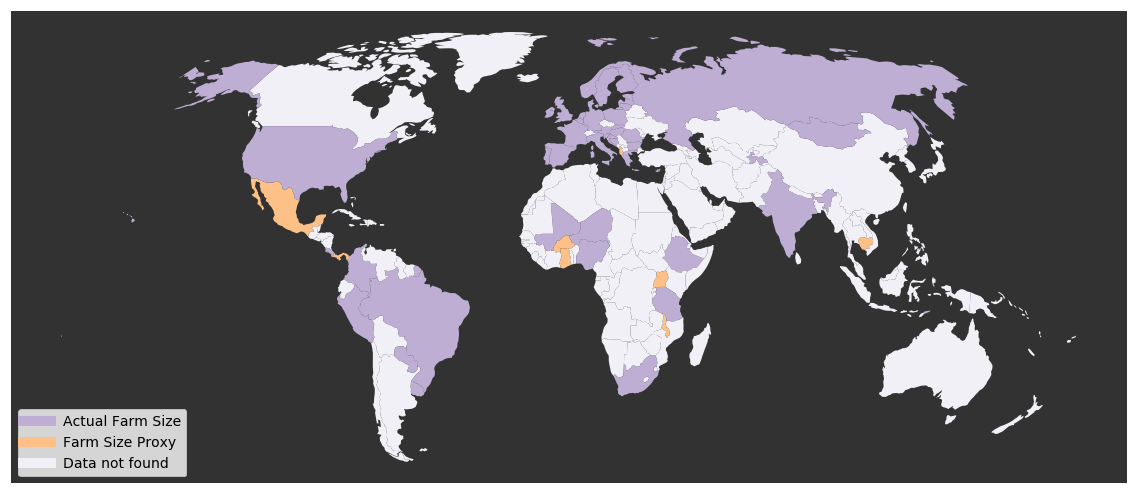

In [21]:
plot_bias(df, variable='fs_proxy', bias='Farm Size Proxy', nobias='Actual Farm Size')

In [22]:
tmp = df.copy()
names_nobias = len(tmp.loc[tmp['fs_proxy'] == 0.]['NAME_0'].unique())
names_bias = len(tmp.loc[tmp['fs_proxy'] == 1.]['NAME_0'].unique())
perc_prod = round(100 * tmp.loc[tmp['fs_proxy'] == 1.]['production_kcal'].sum() / tmp['production_kcal'].sum(), 1)
tmp2 = tmp.loc[(tmp['fs_proxy'] == 0.) & (tmp['microdata'] == 1.)]
test_names = tmp2.loc[(tmp2['Harvested_area'] > 0.) |
                          (tmp2['Cultivated_area'] > 0.) |
                          (tmp2['Crop_area'] > 0.) |
                          (tmp2['Planted_area'] > 0.)]['NAME_0'].unique()
test_names_len = len(test_names)
test_names = list(test_names)
last_name = test_names[-1:]
test_names = test_names[:-1]
test_names = ', '.join(test_names)
test_names = test_names + ', and ' + last_name[0]

Of the microdata used, there were {{names_bias}} countries that did not report actual farm size, but did report either harvested, cropped, planted, or plot area for each crop by farm size. For these countries, we constructed proxy farm sizes using these area variables. In total, the bias from constructing a farm size proxy may affect {{perc_prod}}% of our data. We could not directly test this bias, due to data constraints. But since it affects a small portion of our data, the bias will be minimal.

<a name="Spatial_Bias"></a>
<h2>Spatial Bias</h2><br>

In [23]:
try:
    PATH1 = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    df = pd.read_csv(PATH1, low_memory=False)
    PATH2 = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/FaoStat/FAOSTAT/Production_Crops_E_All_Data_(Normalized)_with_regions.csv'
    fao = pd.read_csv(PATH2)
    reg = pd.read_csv('/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
except:
    PATH1 = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    df = pd.read_csv(PATH1, low_memory=False)
    PATH2 = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/FaoStat/FAOSTAT/Production_Crops_E_All_Data_(Normalized)_with_regions.csv'
    fao = pd.read_csv(PATH2)
    reg = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
    
    
year = int(round(df['year'].mean(), 0))
has = list(df['NAME_0'].unique())

for t in ['Area harvested', 'Production']:
    tmp1 = fao.loc[(fao['Area'] == 'World') & (fao['Element'] == t) & (fao['Year'] == year)]
    tmp2 = fao.loc[(fao['Area'].isin(has)) & (fao['Element'] == t) & (fao['Year'] == year)]
    perc = tmp2.Value.sum() / tmp1.Value.sum()
    if t is 'Production':
        p = perc
    else:
        a = perc
# print p, a

df = df.query("production_Food_kcal == production_Food_kcal")

df['NAME_0'].replace(['United States of America'], ['United States'], inplace=True)
df['NAME_0'].replace(['Bosnia and Herzegovina'], ['Bosnia and Herz.'], inplace=True)
df['NAME_0'].replace(['United Republic of Tanzania'], ['Tanzania'], inplace=True)
df['NAME_0'].replace(['Russian Federation'], ['Russia'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)
df['NAME_0'].replace(['Czech Republic'], ['Czech Rep.'], inplace=True)

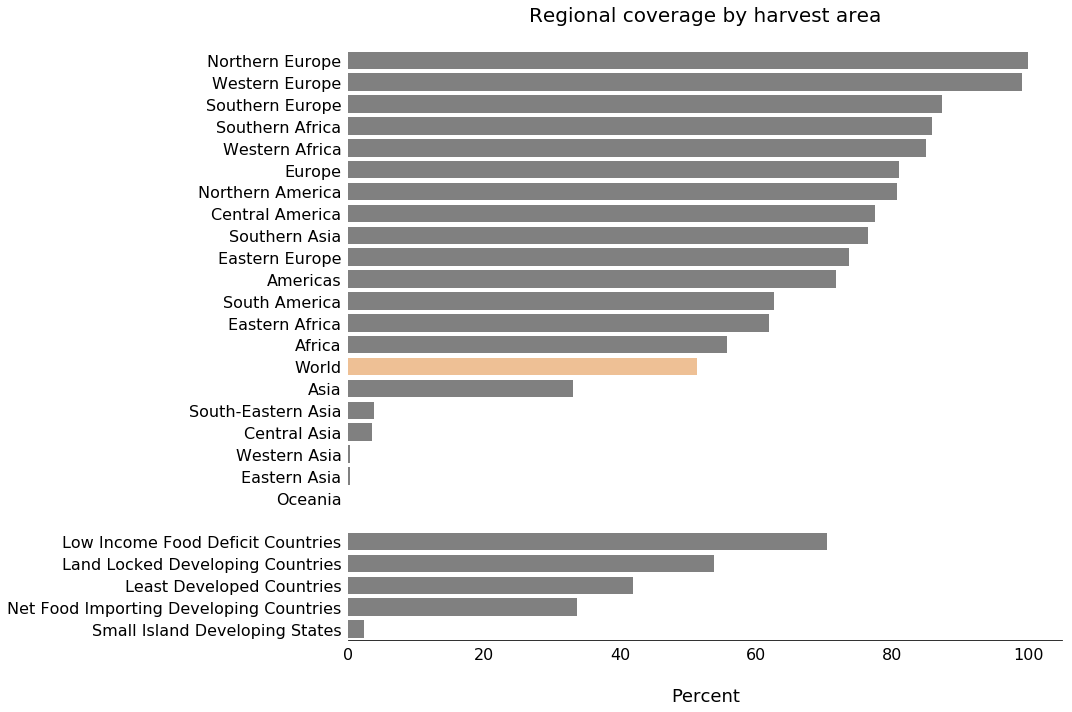

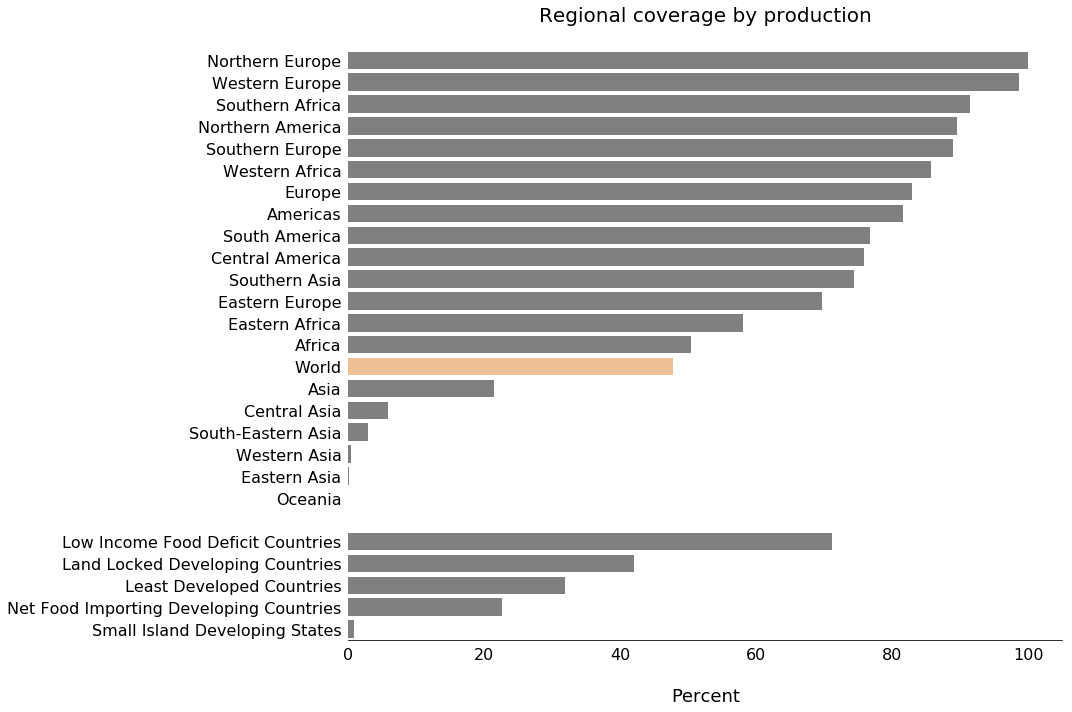

In [51]:
def plot_regional_coverage(how='Area harvested', title='None'):
    
    has_df = pd.DataFrame(has, columns=['Country'])
    has_df = pd.merge(has_df, reg, on='Country', how='outer')

    tmp = fao.loc[(fao['Element'] == how) & (fao['Year'] == 2011)]
    
    tmp = pd.merge(tmp, has_df, 
                   left_on='Area',
                   right_on='Country', 
                   how='outer', 
                   suffixes=['x', 'y'])

    pivot1 = pd.pivot_table(tmp, index='Country Group', values='Value', aggfunc=np.nansum).reset_index()

    tmp2 = tmp.loc[tmp['Area'].isin(has)]
    pivot2 = pd.pivot_table(tmp2, index='Country Group', values='Value', aggfunc=np.nansum).reset_index()
    pivot3 = pd.merge(pivot1, pivot2, on='Country Group', how='right')
    pivot3['perc'] = pivot3['Value_y'] / pivot3['Value_x']
    
    regions = ['Africa', 'Americas', 'Asia', 'Central America', 'Central Asia',
               'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Europe',
               'Northern America', 'Northern Europe', 'Oceania',
               'South America', 'South-Eastern Asia', 'Southern Africa','Southern Asia', 
               'Southern Europe', 'Western Africa', 'Western Asia', 'Western Europe', 'World']

    groupings = ['Low Income Food Deficit Countries', 'Net Food Importing Developing Countries', 
                 'Least Developed Countries', 'Land Locked Developing Countries', 
                 'Small Island Developing States']
    
    pivot4 = pivot3.loc[pivot3['Country Group'].isin(regions)]
    # Hard code in Oceania, was only missing region in dataset
    pivot4 = pivot4.append(pd.DataFrame([['Oceania', 0., 0., 0.]], columns=pivot4.columns), ignore_index=True)
    pivot4 = pivot4.append(pd.DataFrame([['', 0., 0., 0.]], columns=pivot4.columns), ignore_index=True)
    pivot5 = pivot3.loc[pivot3['Country Group'].isin(groupings)]
    pivot4 = pivot4.sort_values('perc', ascending=False)
    pivot5 = pivot5.sort_values('perc', ascending=False)
    pivot4 = pd.concat([pivot4, pivot5])
    
    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(111)

    clrs = ['grey' if (x != 'World') else '#fdc086' for x in pivot4['Country Group']]
    sns.barplot(pivot4['perc'], pivot4['Country Group'], 
                palette=clrs,
                ax=ax);
    ax.set_title('Regional coverage by {}\n'.format(title.lower()), fontsize=20)
    ax.set_xlabel('\nPercent', fontsize=18)
    ax.set_ylabel('')
    ax.grid(alpha=0.0)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticklabels('')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_xticklabels('a')
    ax.set_xticklabels(np.arange(0,101,20))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    fig.tight_layout()
    fig.savefig('/Users/Vinny_Ricciardi/Desktop/sens_regional_{}.png'.format(how))
    
    return plt.show()

plot_regional_coverage(how='Area harvested', title='Harvest Area')
plot_regional_coverage(how='Production', title='Production')

Below shows the mean kcal of food produced when each country is omitted. The vertical black line is the mean kcal of food produced when no countries are omitted. If a country is to the left of the black line it lowers the global average. The vertical white lines are the upper and lower bounds for the range of food production - these values are in each plot's title. Note, there are only four countries per plot shown for the visualization's simplicity, but all data is present.

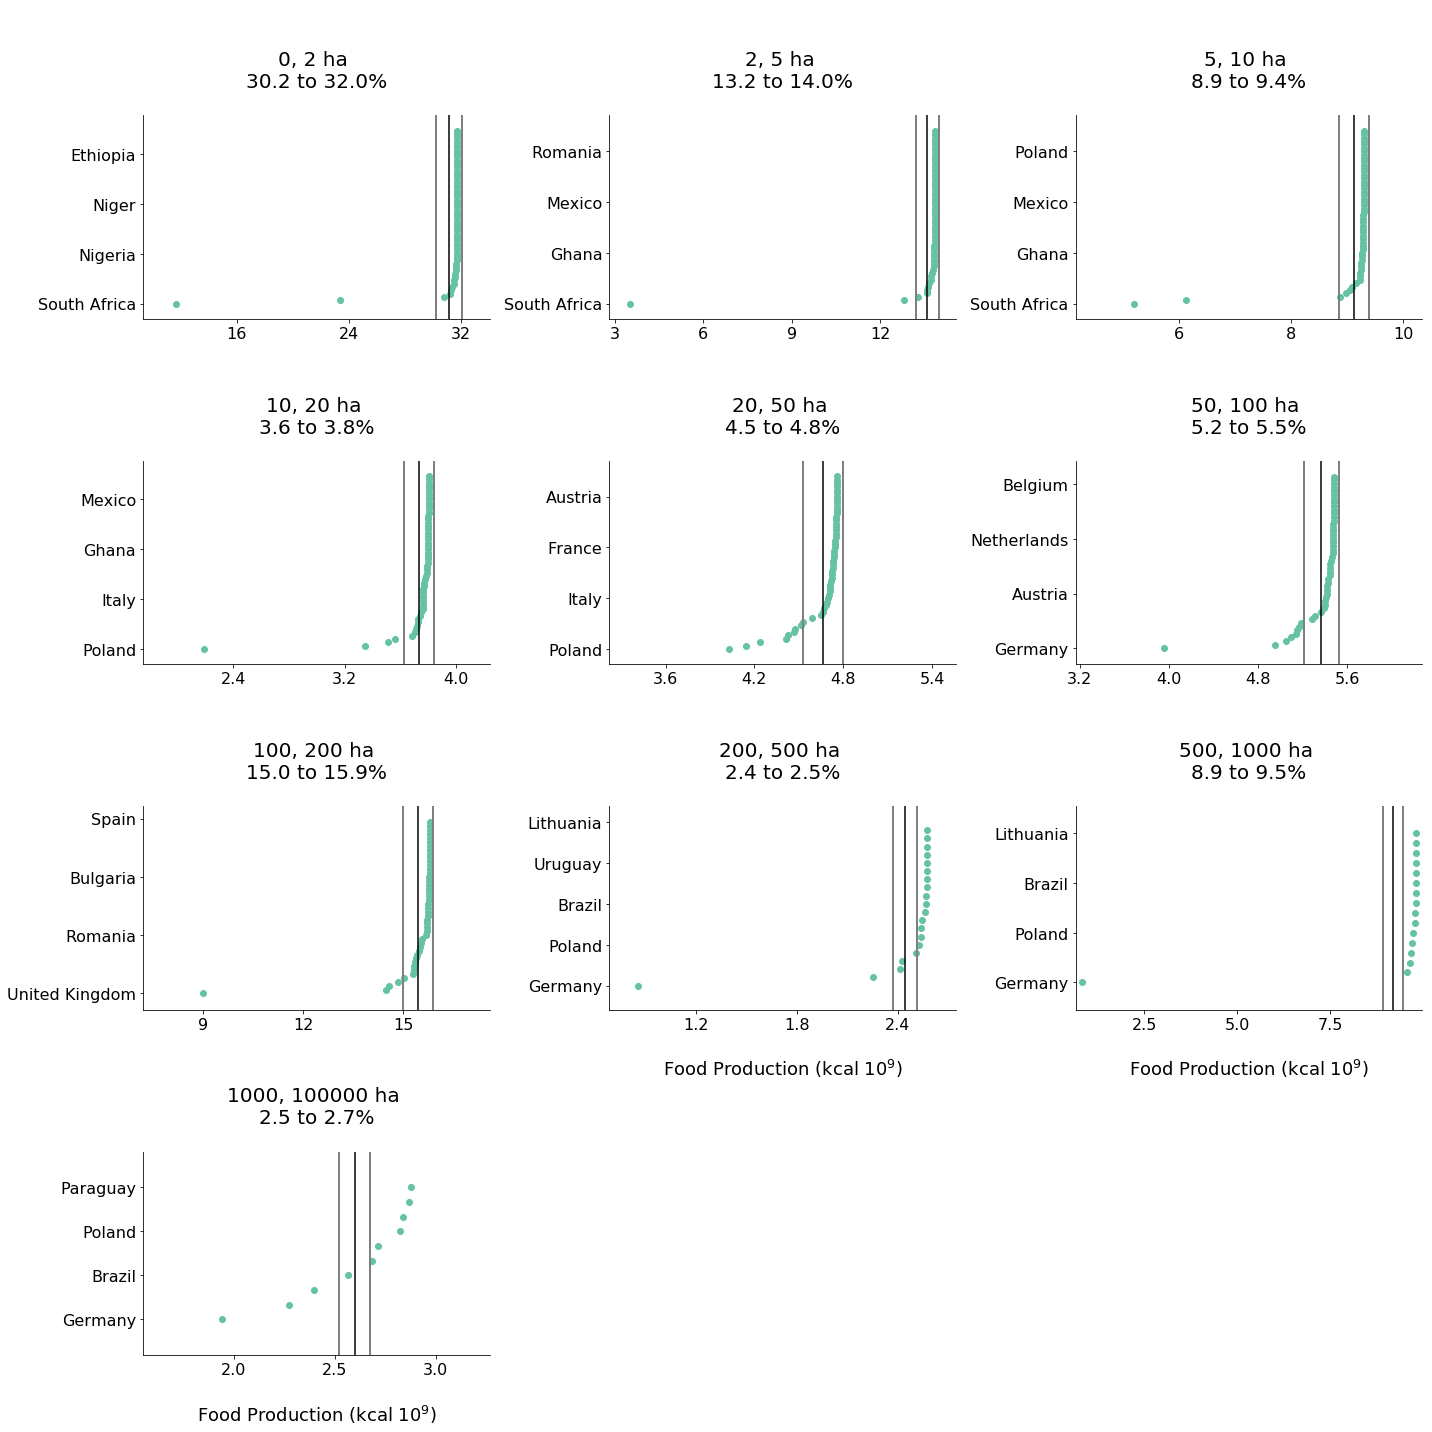

In [46]:
def jacknife_prep(path, how='under2'):
    
    data = pd.read_csv(PATH1, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    if how is 'under2':

        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                    bins=[0, 2, 5, 10, 20, 50,
                                          100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
                    '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']

        fs_txt = ['< 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']
        
    else:
        
        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                        bins=[0, 1, 2, 5, 10, 20, 50,
                                              100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']
                        
        fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']

    variables = ['NAME_0',  
                 'Farm_Sizes', 
                 'production_Food_kcal']
    
    data = data.loc[:, variables]
    data = data.dropna()
    
    return data, fs_order, fs_txt
    
    
def jacknife(data, variable='production_Food_kcal'):

    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    data['ix'] = data['Farm_Sizes'].map(dictionary)

    out = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])
    
    fsize = []
    ixs = []

    for f, ix in zip(data['Farm_Sizes'].unique(), data['ix'].unique()):
        
        out2 = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])

        tmp = data.loc[data['Farm_Sizes'] == f]

        tmp = tmp.sort_values('ix')
        
        names = []
        
        for i in tmp.NAME_0.unique():
            
            tmp2 = tmp[tmp['NAME_0'] != i]

            pivot = pd.pivot_table(tmp2, 
                                   index=['ix'],
                                   values=variable, 
                                   aggfunc=np.nansum).reset_index()

            pivot['NAME_0'] = i
            pivot['Farm_Sizes'] = f
            pivot['ix'] = ix
            out2 = pd.concat([out2, pivot])
            
        out2['tot_mean'] = np.nanmean(out2[variable])
        out2['mj_m_2'] = (out2[variable] - out2['tot_mean'])**2
        out2['s'] = np.sqrt(np.nansum(out2['mj_m_2']) / float(len(tmp.NAME_0.unique()) - 1))
        out2['se'] = out2['s'] / np.sqrt(len(tmp.NAME_0.unique()) - 1)
        out2['ci_high'] = out2['tot_mean'] + (2.09 * out2['se'])  # 2.09 is the upper 0.25% of the t-distribution
        out2['ci_low'] = out2['tot_mean'] - (2.09 * out2['se'])
        
        out = pd.concat([out, out2])
    
        out['country_mean'] = out['production_Food_kcal']
    
    out = out.drop('production_Food_kcal', 1)
    out['country_mean_p'] = (out['country_mean'] / data['production_Food_kcal'].sum())
    out['country_ci_high_p'] = out['country_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['country_ci_low_p'] = out['country_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    out['fs_mean_p'] = (out['tot_mean'] / data['production_Food_kcal'].sum())
    out['fs_ci_high_p'] = out['fs_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['fs_ci_low_p'] = out['fs_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    
    pivot = pd.pivot_table(out,
                          index=['Farm_Sizes', 'ix'],
                          values=['fs_mean_p', 'fs_ci_high_p', 'fs_ci_low_p']).reset_index()

    pivot.columns = ['Farm_Sizes', 'ix', 'ci_high', 'ci_low', 'mean']

    return out, pivot
    
    
def plot_jacknife_countries(data):

    fig = plt.figure(figsize=[20,20])
    # fs = prods['Farm_Sizes'].unique()
    # fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
    #       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
    #       '(500, 1000]', '(1000, 100000]']

    # fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
    #       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
    #       '(500, 1000]', '(1000, 100000]']

    data['ix_c'] = range(0, len(data))

    for i in xrange(len(fs_order)):

        ax = fig.add_subplot(4,3,i+1)

        tmp = data[data['Farm_Sizes'] == fs_order[i]]
        tmp = tmp.sort('country_mean_p')
        tmp['ix_c'] = range(0, len(tmp['NAME_0']))
        
        ax.plot(100 * tmp['country_mean_p'],
                tmp['ix_c'], 
                c=sns.color_palette("Set2", 3)[0], 
                marker="o", 
                linewidth=0, 
                label='Prod')
        ax.axvline(x=100 * tmp['country_mean_p'].mean(), c='k')
        ax.axvline(x=100 * tmp['fs_ci_low_p'].max(), 
                   color='grey', 
                   linewidth=2)
        ax.axvline(x=100 * tmp['fs_ci_high_p'].max(), 
                   color='grey', 
                   linewidth=2)
        
        ax.set_xlim([100 * tmp['country_mean_p'].min() - (100 * (0.2 * tmp['country_mean_p'].min())), 
                     100 * tmp['country_mean_p'].max() + (100 * (0.2 * tmp['country_mean_p'].min()))])

        ax.set_yticklabels(tmp.NAME_0.unique(), fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        
        if i > 6:
            ax.set_xlabel('\nFood Production (kcal $10^9$)', fontsize=18)
        
        else:
            pass
        
        title = '\n\n{} ha \n{} to {}%\n'.format(fs_order[i][1:-1], 
                                                 round(100 * tmp['fs_ci_low_p'].max(), 1), 
                                                 round(100 * tmp['fs_ci_high_p'].max(), 1))
        
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(title, fontsize=20)
        ax.set_axis_bgcolor("#ffffff")
        ax.set_clip_on(False)
        ax.grid(alpha=0.0)
        #ax.set_xticks(ax.get_xticks()[::2]) 
        ax.set_ylim(ax.get_ylim()[0] - 2, ax.get_ylim()[1] + 2)
        
        ax.xaxis.set_major_locator(MaxNLocator(4))
        ax.yaxis.set_major_locator(MaxNLocator(5))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    fig.tight_layout()
    fig.savefig('/Users/Vinny_Ricciardi/Desktop/sens_jack.png', dpi=1000, bbox_inches='tight')
    
    return plt.show()
    
    
data, fs_order, fs_txt = jacknife_prep(PATH, how='under2')
df_jk, prods = jacknife(data)
plot_jacknife_countries(df_jk)

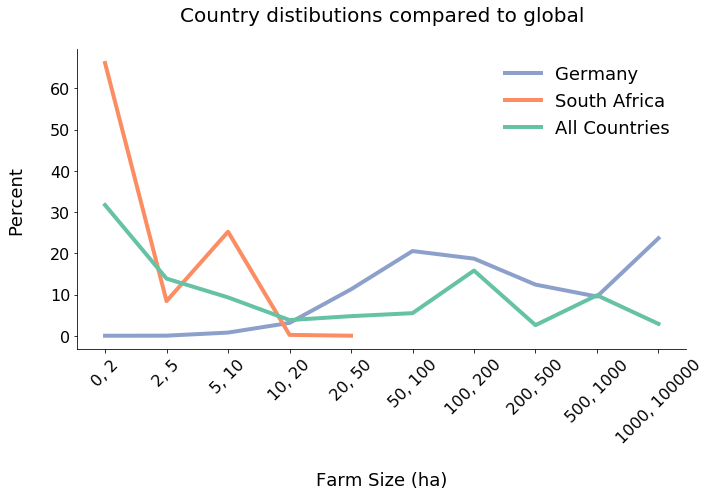

In [57]:
def spot_check_jacknife_plot(data, ax=None):

    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    data['ix'] = data['Farm_Sizes'].map(dictionary)

    pivot1 = pd.pivot_table(data,
                            index=['NAME_0', 'ix', 'Farm_Sizes'],
                            aggfunc=np.nansum).reset_index().dropna()

    pivot2 = pd.pivot_table(data,
                            index=['NAME_0'],
                            values='production_Food_kcal',
                            aggfunc=np.nansum).reset_index().dropna()
    pivot2.head()

    merged = pd.merge(pivot1, pivot2,
                      on=['NAME_0'],
                      how='outer')
    merged['perc'] = merged['production_Food_kcal_x'] / merged['production_Food_kcal_y']
    
    # Compare to global
    pivot3 = pd.pivot_table(data,
                            index=['ix', 'Farm_Sizes'],
                            values='production_Food_kcal',
                            aggfunc=np.nansum).reset_index().dropna()
    pivot3['total'] = pivot3['production_Food_kcal'].sum()
    pivot3['perc'] = pivot3['production_Food_kcal'] / pivot3['total']
    
    tmp = merged.loc[merged['NAME_0'] == 'Germany']
    tmp['perc'].sum()
    
    ax.plot(tmp['ix'].astype(int), 
            100 * tmp['perc'], 
            marker='',
            linestyle='-',
            linewidth=4,
            color=sns.color_palette("Set2", 3)[2],
            label='Germany')
    
    tmp = merged.loc[merged['NAME_0'] == 'South Africa']
    tmp['perc'].sum()
    
    ax.plot(tmp['ix'].astype(int), 
            100 * tmp['perc'], 
            marker='',
            linestyle='-',
            linewidth=4,
            color=sns.color_palette("Set2", 3)[1],
            label='South Africa')
    
    ax.plot(pivot3['ix'].astype(int), 
            100 * pivot3['perc'], 
            marker='',
            linestyle='-',
            color=sns.color_palette("Set2", 3)[0],
            linewidth=4,
            label='All Countries')
    
    ax.set_xticks(np.arange(0, 10, 1.0))
    labels = merged.sort_values('ix')['Farm_Sizes'].unique()
    labels = [x[1:-1] for x in labels]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title('Country distibutions compared to global\n', fontsize=20)
    ax.legend(loc='upper right', frameon=False, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Percent\n', fontsize=18)
    ax.set_xlabel('\nFarm Size (ha)', fontsize=18)

    
    return ax
    
    
fig = plt.figure(figsize=[10, 7])
ax = fig.add_subplot(111)
spot_check_jacknife_plot(data, ax=ax)

fig.tight_layout()
fig.savefig('/Users/Vinny_Ricciardi/Desktop/sens_jack_ex.png', dpi=1000, bbox_inches='tight')
plt.show()

<a name="Data_Comparisons"></a> 
<h2>Comparisons to other datasets</h2><br>
<h3>FAO Crop Production</h3>

In [27]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

In [28]:
try:
    PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)
except:
    PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)

In [29]:
tmp = data_orig.copy()
tmp['fs_proxy'] = np.where(tmp['fs_proxy'] == 1., tmp['fs_proxy'], 0.)
tmp['Production_fix_dummy'] = np.where(tmp['Production_fix_dummy'] == 1., tmp['Production_fix_dummy'], 0.)
tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal']

tmp['Prod_FAO'] = tmp['Area_FAO'] * tmp['Yield_FAO']
tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal']

pivot = pd.pivot_table(tmp, 
                       index=['NAME_0', 'year', 'fs_proxy', 'cen_sur', 'Production_fix_dummy'],  # 'NAME_1', 'NAME_2', 'NAME_3'
                       values=['Prod_FAO_kcal', 'production_kcal'],
                       aggfunc=np.nansum)

pivot1 = pivot.reset_index()

In [30]:
def models_fao_v_ours(data):

    tmp = data.copy()
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

    x = tmp['log_Prod_FAO_kcal']
    y = tmp['log_production_kcal']

    X = x.as_matrix()
    y = y.as_matrix()
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit line using all data
    lr = linear_model.LinearRegression(normalize=True)
    lr.fit(X, y)

    # Robustly fit linear model with RANSAC algorithm
    # ransac = linear_model.RANSACRegressor(max_trials=10000)
    # ransac.fit(X, y)
    
    # Since RANSAC is not stable, use Huber, 
    # a non-parametric robust regression 
    # where outliers are de-weighted, not excluded
    
    huber = HuberRegressor(fit_intercept=True, 
                           alpha=0.00, 
                           max_iter=10000,
                           epsilon=1.35)
    huber.fit(X, y)
    
    return lr, huber, X, y
    
    
def plot_all_fao_v_ours(data, bias='All Farms', ax=None):
    
    lr, huber, X, y = models_fao_v_ours(data)

    tmp = pd.concat([pd.DataFrame(X, columns=['x']), pd.DataFrame(y, columns=['y'])], axis=1)
    sns.regplot(x='x', y='y', data=tmp, ax=ax, color='grey')
    ax.set_xlabel('\nFAO data produced \n(log kcal)', fontsize=18)
    ax.set_ylabel('Our data food produced \n(log kcal)\n', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title('\n{} \n'
                 'Spearman rank: {} \n '.format(bias,
                                                round(spearmanr(X, y)[0], 2)),
                fontsize=20)
    
    return ax

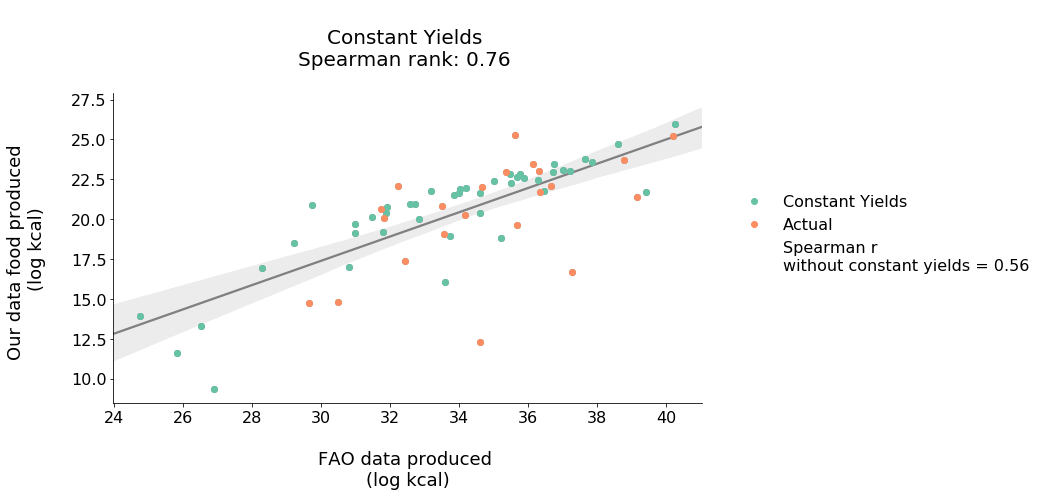

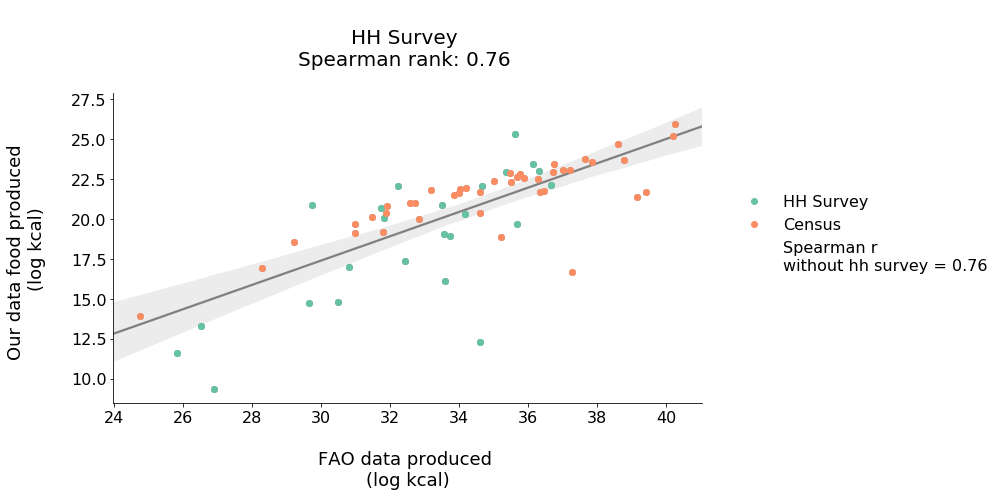

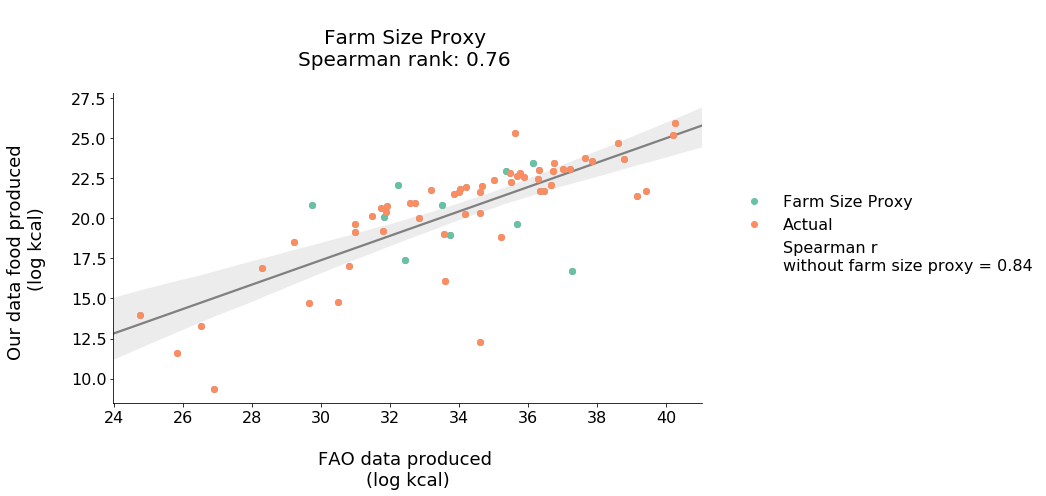

In [31]:
for i, j, k, t in zip(['Production_fix_dummy', 'cen_sur', 'fs_proxy'], 
                      [1., 'sur', 1.], 
                      [['Constant Yields', 'Actual'],
                       ['HH Survey', 'Census'], 
                       ['Farm Size Proxy', 'Actual']],
                      ['Constant yields bias', 
                       'Family farm bias',
                       'Plot size as farm size proxy bias']):
    
    fig = plt.figure(figsize=[10, 7])
    ax = fig.add_subplot(111)
    
    tmp1 = pivot1.loc[pivot1[i] != j]
    tmp1 = tmp1.loc[(tmp1['Prod_FAO_kcal'] > 0.) & (tmp1['production_kcal'] > 0.)]
    corr_wo = round(spearmanr(np.log(tmp1['Prod_FAO_kcal']), np.log(tmp1['production_kcal']))[0], 2)
    
    plot_all_fao_v_ours(pivot1, bias=k[0], ax=ax);
    
    tmp2 = pivot1.loc[pivot1[i] == j]
    
    ax.plot(np.log(tmp2['Prod_FAO_kcal']), np.log(tmp2['production_kcal']), 
            color=sns.color_palette("Set2", 3)[0], 
            label=k[0], 
            marker='o', 
            linewidth=0.)
    
    ax.plot(np.log(tmp1['Prod_FAO_kcal']), np.log(tmp1['production_kcal']), 
            color=sns.color_palette("Set2", 3)[1], 
            label=k[1],
            marker='o',
            linewidth=0.)
    
    ax.plot(np.log(tmp1['Prod_FAO_kcal']), np.log(tmp1['production_kcal']), 
            color=sns.color_palette("Set2", 3)[1], 
            label='Spearman r \nwithout {} = {}'.format(str.lower(k[0]), corr_wo),
            marker='o',
            alpha=0.,
            linewidth=0.)
    
    ax.legend(loc=[1.05, 0.4], frameon=False, fontsize=16)

    fig.tight_layout()
    fig.savefig('/Users/Vinny_Ricciardi/Desktop/sens_againstFAO_{}.png'.format(i), 
                dpi=1000, bbox_inches='tight')
    fig.show()

In [32]:
lr, huber, X, y = models_fao_v_ours(pivot1)

spearman = round(spearmanr(X, y)[0], 2)

corrs = []
names = []

for i in pivot1['NAME_0'].unique():
    
    tmp = pivot1.loc[pivot1['NAME_0'] != i]
    
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

    x = tmp['log_Prod_FAO_kcal']
    y = tmp['log_production_kcal']

    X = x.as_matrix()
    y = y.as_matrix()
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    corrs.append(spearmanr(X, y)[0])
    names.append(i)
    
out = pd.concat([pd.DataFrame(names, columns=['NAME_0']), 
                 pd.DataFrame(corrs, columns=['corrs'])],
                axis=1)
out = out.sort_values('corrs')
min_corr = round(out['corrs'].min(), 2)
min_country = out.iloc[0,0]
max_corr = round(out['corrs'].max(), 2)
max_country = out.iloc[-1,0]

There is a spearman rank correlation of {{spearman}} between our data and the FAO data (in tonnes of production for the same crops, countries, and years. To test whether any error in this correlation was due to a particular country, we used the Jacknife technique. Still the range in correlations are close to the mean ({{min_corr}} to {{max_corr}}).

<h3>Lowder et al. 2015 farm size distribution</h3><br><br>

Note: We could not directly compare with Lowder et al., because we have production and gross area by farm size, her dataset has agricultural area (net) by farm size.

In [33]:
# try:
#     PATH_lowder = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/External_Datasets/Lowder_Supp_cleaned.csv'
#     lowder = pd.read_csv(PATH_lowder)
# except:
#     PATH_lowder = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/External_Datasets/Lowder_Supp_cleaned.csv'
#     lowder = pd.read_csv(PATH_lowder)
    
# lowder = lowder.loc[lowder['Holdings/ agricultural area'] != 'Holdings']
# lowder = lowder.drop(lowder[[u'year', u'Region', u'Holdings/ agricultural area']], axis=1)
    
# has = pd.DataFrame(lowder.NAME_0.unique(), columns=['NAME_0'])
# ours = pd.DataFrame(data_orig.query("production_Food_kcal == production_Food_kcal").NAME_0.unique(), 
#                     columns=['NAME_0'])
# together = pd.merge(has, ours, how='inner', on='NAME_0', indicator=True)
# num_tog = len(together.NAME_0.unique())  # number of countries in common

In [93]:
# for c in lowder.columns[2:]:
#     lowder[c] = lowder[c] / lowder['Total']

# lowder = lowder.drop(['Total'], axis=1)
# lowder = pd.melt(lowder, 
#                  id_vars=['NAME_0'], 
#                  var_name='Farm_Sizes', 
#                  value_name='Lowder_Perc_Farms')

In [94]:
# data_orig.head()
# tmp = data_orig.loc[:, ['NAME_0', 'Farm_Sizes', 'Production_fix']]
# tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str)
# tmp = pd.pivot_table(tmp, 
#                      index=['NAME_0'],
#                      columns='Farm_Sizes',
#                      aggfunc=np.nansum)

# tmp.columns = tmp.columns.droplevel()

# tmp['Total'] = tmp.sum(axis=1)
# for c in tmp.columns[:-1]:
#     tmp[c] = tmp[c] / tmp['Total']

# tmp = tmp.drop(['Total'], axis=1)
# tmp = tmp.reset_index()
# tmp = pd.melt(tmp, 
#                  id_vars=['NAME_0'], 
#                  var_name='Farm_Sizes', 
#                  value_name='Ours_Perc_Farms')

In [95]:
# merged = pd.merge(tmp, lowder,
#                   on=['NAME_0', 'Farm_Sizes'],
#                   how='inner')

In [96]:
# stacked = pd.melt(merged, id_vars=['NAME_0', 'Farm_Sizes'])
# g = sns.factorplot(x="variable", 
#                    y="value",
#                    col="Farm_Sizes", 
#                    data=stacked, 
#                    kind='box', 
#                    col_wrap=4,
#                    palette=sns.color_palette("Set2", 3))

In [97]:
# def comparing_data(data):

#     ids = []
#     ts = []
#     ps = []
#     names = []

#     for f in data['Farm_Sizes'].unique():

#         tmp = data.copy()
#         tmp = tmp.loc[tmp['Farm_Sizes'] == f]
        
#         for n in tmp['NAME_0'].unique():
            
#             tmp2 = tmp.loc[tmp['NAME_0'] != n]
#             tmp2 = tmp2.dropna()
#             ours = tmp2['Ours_Perc_Farms'].as_matrix()
#             lowders = tmp2['Lowder_Perc_Farms'].as_matrix()
#             t, p = stats.ttest_ind(ours, lowders)
#             ids.append(f)
#             names.append(n)
#             ts.append(round(t, 2))
#             ps.append(round(p, 3)) 

#     out = pd.concat([pd.DataFrame(ids, columns=['Farm_Sizes']),
#                      pd.DataFrame(names, columns=['names']),
#                      pd.DataFrame(ts, columns=['ts']),
#                      pd.DataFrame(ps, columns=['ps'])],
#                    axis=1)
#     out = out.sort_values('ps')
    
#     return out
    
# def plot_compare_ps(data):
    
#     order = pd.pivot_table(data,
#                            index=['Farm_Sizes'],
#                            values=['ts', 'ps'],
#                            aggfunc=np.nanmean).reset_index()
#     order = order.sort_values('ps')
#     order['ix'] = range(0, len(order))
#     order = order.loc[:, ['Farm_Sizes', 'ix']]
    
#     data = pd.merge(data, order, how='left', on='Farm_Sizes')
#     data = data.sort_values('ix')
    
#     fig = plt.figure(figsize=[10, 5])
#     ax= fig.add_subplot(111)

#     sns.barplot(x='Farm_Sizes',
#                 y='ps', 
#                 data=data, 
#                 color='grey', 
#                 ax=ax)

#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     #labels = [x[1:-1] + '\n t = ' + str(y) for x, y in zip(labels, out['ts'])]
#     labels = [x[1:-1] for x in labels]
#     ax.set_xticklabels(labels, rotation=45)
#     ax.set_xlabel('Farm Sizes (ha)')
#     ax.set_ylabel('p values')
#     ax.set_title('Comparison of Lowder to our data \n\nTwo-tailed independent t-tests \n per farm size class\n',
#                 fontsize=14);
    
#     ax.axhline(y=0.05, linewidth=1, color='r', alpha=0.4)
    
#     return plt.show()

In [98]:
# d = comparing_data(merged)
# plot_compare_ps(d)

In [99]:
# Any farm size class over the red line (p > 0.05) showed significant differences between our data's area distributions per farm size class and Lowder et al.'s. The error bars are from a jacknife iteration where each country was omitted before running a two tailed independent t-test. Significant differences occured between the two datasets for farm size classes: 20 to 50, 100 to 200, 50 to 100, and 1 to 2 ha. This may due Lowder et al. relying on older census information ranging from 1987 to 2005 (average of 1998). Note, the differences between datasets may also be due to our data has a family farm bias in several of our countries as explained [above](#Farm_Size_Proxy), however, only 3 of the 15 countries our data has with a family farm bias overlap with Lowder et al.'s data, so this is likely not the case.

In [100]:
# tmp = data_orig.loc[:, ['NAME_0', 'fs_proxy', 'cen_sur']]
# merged = pd.merge(merged, tmp,
#                   on='NAME_0',
#                   how='left')

In [101]:
# colors_ = ['#97d6b9',
#            '#73c8bd',
#            '#52bcc2',
#            '#37acc3',
#            '#2498c1',
#            '#1f80b8',
#            '#2165ab',
#            '#234da0',
#            '#253795',
#            '#172978',
#            '#081d58'] 

# fig = plt.figure(figsize=[15, 15])

# for i in xrange(0, len(merged['Farm_Sizes'].unique())):
    
#     tmp = merged.loc[merged['Farm_Sizes'] == merged['Farm_Sizes'].unique()[i]]
#     tmp1 = tmp.loc[tmp['cen_sur'] == 'cen']
#     tmp2 = tmp.loc[tmp['cen_sur'] != 'cen']
    
#     ax = fig.add_subplot(4, 3, i+1)
#     ax.plot(tmp1['Ours_Perc_Farms'], tmp1['Lowder_Perc_Farms'], 'r.')
#     ax.plot(tmp2['Ours_Perc_Farms'], tmp2['Lowder_Perc_Farms'], 'b.')
#     ax.set_xlim([0, 1])
#     ax.set_ylim([0, 1])
#     x = np.linspace(0, ax.get_xlim()[1])
#     ax.plot(x, x, 'k-')
#     ax.set_xlabel('Our data')
#     ax.set_ylabel('Lowder et al.')
    

In [102]:
# pivot = pd.pivot_table(merged, 
#                        index=['Farm_Sizes', 'NAME_0'],
#                        aggfunc=np.max).reset_index()
# pivot['ratio'] = pivot['Lowder_Perc_Farms'] / pivot['Ours_Perc_Farms']
# pivot['fs_proxy'] = np.where(pivot['fs_proxy'] != 1., 0, 1.)
# pivot = pivot.dropna()